Exploratory Data Analysis

This section will cover:

initial exploratory analysis, 
grammar and spelling correction, 
feature extraction with SpaCy.

In [6]:
%matplotlib inline

import numpy as np
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

# import language_check
import joblib

# import sklearn.external.joblib as extjoblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

plt.style.use('seaborn-colorblind')

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)

plt.rcParams['figure.dpi']= 100

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [79]:
training_set  = pd.read_csv('train_rel_2.tsv', sep='\t', encoding = "ISO-8859-1")\
             .rename(columns={'EssaySet': 'Topic', 'Score1': 'TargetScore1', 'Score2': 'TargetScore2'})
training_set.sample()

,Id,Topic,TargetScore1,TargetScore2,EssayText
6070,9431,4,0,1,"The significance of the word invasive is taking over. According to the article. ""The pet industr..."


In [80]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17043 entries, 0 to 17042
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            17043 non-null  int64 
 1   Topic         17043 non-null  int64 
 2   TargetScore1  17043 non-null  int64 
 3   TargetScore2  17043 non-null  int64 
 4   EssayText     17043 non-null  object
dtypes: int64(4), object(1)
memory usage: 665.9+ KB


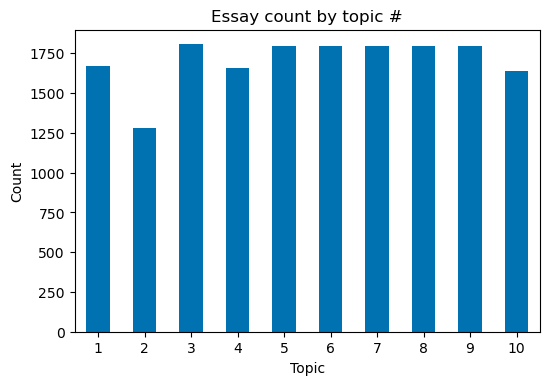

In [81]:
training_set.groupby('Topic').agg('count').plot.bar(y='EssayText', rot=0, legend=False)
plt.title('Essay count by topic #')
plt.ylabel('Count')
plt.show()

Since topic 2 has the fewest essays and the most distinct scores, it might prove to be the most challenging topic to model.

In [82]:
# Count characters and words for each essay
training_set['word_count'] = training_set['EssayText'].str.strip().str.split().str.len()

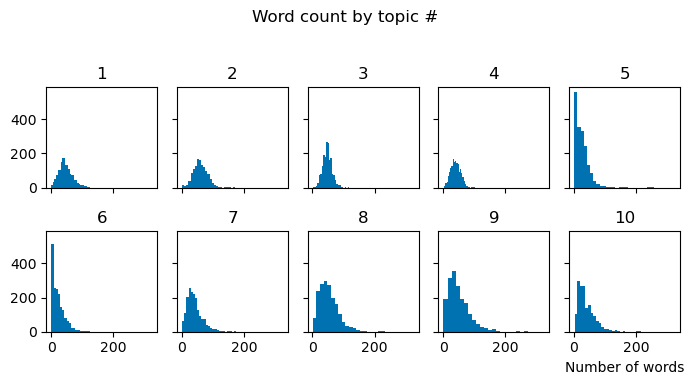

In [83]:
training_set.hist(column='word_count', by='Topic', bins=25, sharey=True, sharex=True, layout=(2, 5), figsize=(7,4), rot=0) 
plt.suptitle('Word count by topic #')
plt.xlabel('Number of words')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [84]:
training_set.columns

Index(['Id', 'Topic', 'TargetScore1', 'TargetScore2', 'EssayText', 'word_count'], dtype='object')

In [86]:
training_set.groupby(['Topic'])['TargetScore1'].agg(['min','max','count','nunique'])

,min,max,count,nunique
Topic,,,,
1,0,3,1672,4
2,0,3,1278,4
3,0,2,1808,3
4,0,2,1657,3
5,0,3,1795,4
6,0,3,1797,4
7,0,2,1799,3
8,0,2,1799,3
9,0,2,1798,3


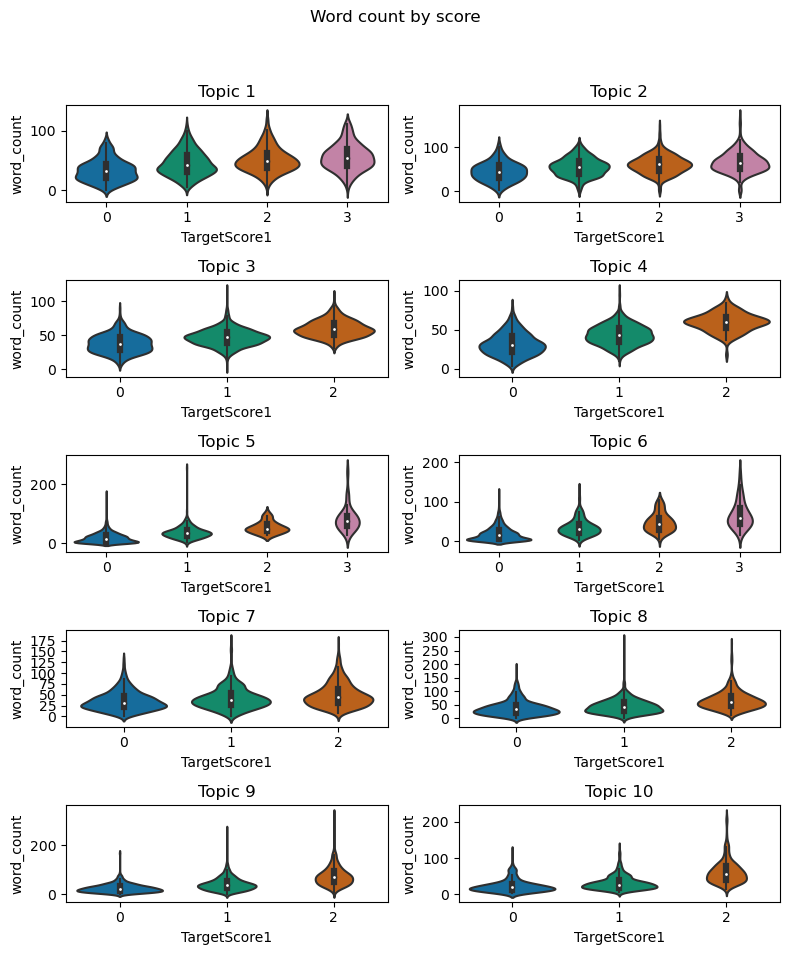

In [88]:
topic_number = 0
fig, ax = plt.subplots(5,2, figsize=(8,10))
for i in range(5):
    for j in range(2):
        topic_number += 1
        data=training_set[training_set['Topic'] == topic_number]
        sns.violinplot(x='TargetScore1', y='word_count', data=data, ax=ax[i,j])
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Word count by score')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [78]:
training_set.columns

Index(['Id', 'Topic', 'TargetScore1', 'TargetScore1', 'EssayText', 'word_count'], dtype='object')

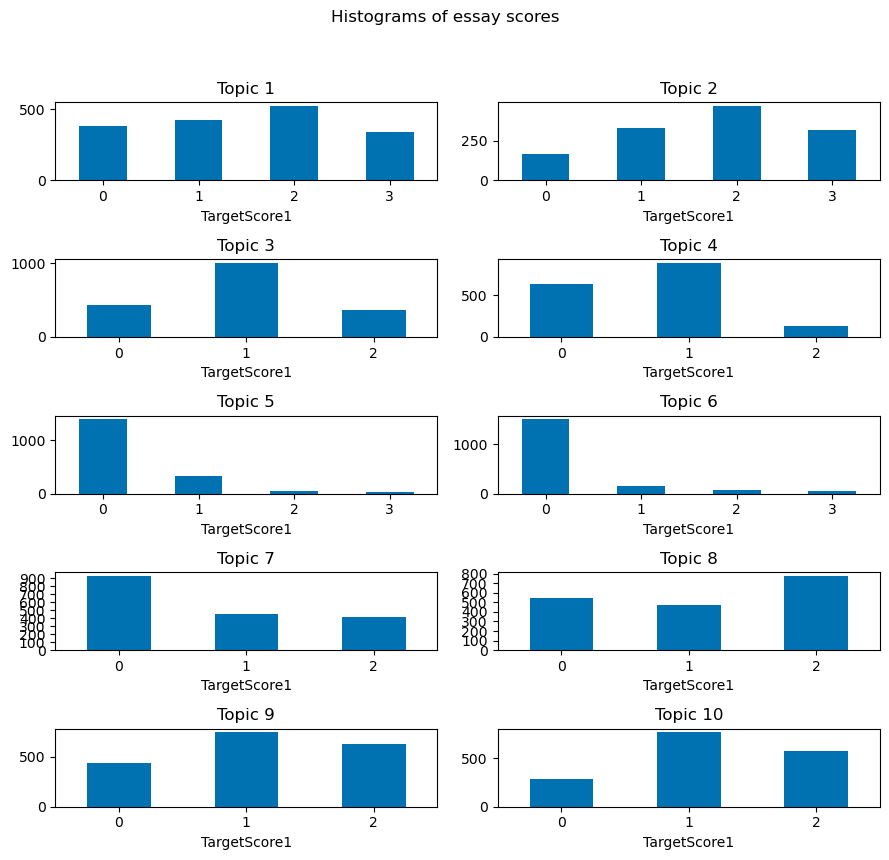

In [90]:
topic_number = 0
fig, ax = plt.subplots(5,2, figsize=(9,9), sharey=False)
for i in range(5):
    for j in range(2):
        topic_number += 1
        training_set[training_set['Topic'] == topic_number]\
            .groupby('TargetScore1')['Id']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Histograms of essay scores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Many scores are underrepresented. Classification could be difficult without rebalancing.

Essay processing:
1.Language correction with languagetool (add number of corrections as feature)
2.Sentence tokenization with Spacy
3.Sentence count and length
4.Word tokenize with Spacy
5.Word token classification (punctuation, stop words and anonymized entities, pos, ent)
6.Document similarity (based on arbitrary high scoring essay for each topic)

Grammar and spelling
As to be expected with student essays, many essays exhibit grammar and spelling errors.

In [94]:
# import lanuage_check
# tool = language_check.LanguageTool('en-US')

# matches = tool.check(text)
# language_check.correct(text, matches)

NLP with SpaCy

In [103]:
sents = []
tokens = []
lemma = []
pos = []
ner = []

stop_words = set(STOP_WORDS)
stop_words.update(punctuation) # remove it if you need punctuation 


nlp = spacy.load('en_core_web_sm')

t0 = datetime.now()

# suppress numpy warnings
np.warnings.filterwarnings('ignore')

for essay in nlp.pipe(training_set['EssayText'], batch_size=100):
    if essay.is_parsed:
        tokens.append([e.text for e in essay])
#         sents.append([sent.string.strip() for sent in essay.sents])
        pos.append([e.pos_ for e in essay])
        ner.append([e.text for e in essay.ents])
        lemma.append([n.lemma_ for n in essay])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
#         sents.append(None)
        ner.append(None)

training_set['tokens'] = tokens
training_set['lemma'] = lemma
training_set['pos'] = pos
# training_set['sents'] = sents
training_set['ner'] = ner

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

Processing time: 0:02:06.321552


In [104]:
training_set.to_pickle('training_spacy.pkl')